In [48]:
'''

The purpose/objective of this notebook is :


The following notebooks should be run before this notebook or are used to generate input files for the notebook:




# save all the global variable in a dataclass G
@dataclass
class G():
    Class to hold global variables
    write_dir='/home/ubuntu/write/'
    repo_parent_dir='../../'
    WRITE_CACHE=False
    #input files

    #output files

    #variables to change
    save_output=True
    save_output_figures=False


'''

"\n\nThe purpose/objective of this notebook is :\n\n\nThe following notebooks should be run before this notebook or are used to generate input files for the notebook:\n\n\n\n\n# save all the global variable in a dataclass G\n@dataclass\nclass G():\n    Class to hold global variables\n    write_dir='/home/ubuntu/write/'\n    repo_parent_dir='../../'\n    WRITE_CACHE=False\n    #input files\n\n    #output files\n\n    #variables to change\n    save_output=True\n    save_output_figures=False\n\n\n"

In [49]:
%%bash
cd
pwd
cd /home/ubuntu/data/ARCHS4/
ls

/home/ubuntu
archs4_gene_human_v2.1.2.h5
human_gene_v2.2.h5


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


## Global variables

In [50]:
# save all the global variable in a dataclass G
from dataclasses import dataclass
@dataclass
class G():
    '''Class to hold global variables'''
    write_dir='/home/ubuntu/write/'
    repo_parent_dir='../../'
    WRITE_CACHE=False
    #input files
    #ARCHS4_H5_file='/home/ubuntu/data/ARCHS4/archs4_gene_human_v2.1.2.h5'
    ARCHS4_H5_file='/home/ubuntu/data/ARCHS4/human_gene_v2.2.h5'

    #output files
    filtered_meta_data_csv_file='meta_samples_dermatitis.csv'

    #variables to change
    save_output=True
    save_output_figures=False

    

# libraries standard paths and settings

In [51]:
#write_dir='/home/ubuntu/write/'
#repo_parent_dir='../../'

import sys
if G.repo_parent_dir not in sys.path:
    sys.path.append(G.repo_parent_dir)

import adata_and_scanpy_tools as adsctl

import pandas as pd
import scanpy as sc
import numpy as np
import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

#WRITE_CACHE=False # use false if  in github repo or cache files not in git ignore

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


In [52]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [53]:
### import extra packages
import h5py
import scipy as sp
import h5sparse

# Analysis starts here:

### filter  and other functions

In [54]:
def load_ARCHS4_H5_to_df( ARCHS4_H5_file):
    '''load a ARCHS4_H5 file to a pandas dataframe'''
    ARCHS4_H5=h5py.File(G.ARCHS4_H5_file, 'r'   )
    meta_samples = ARCHS4_H5['meta/samples']
    df = pd.DataFrame()
    for name, item in meta_samples.items():
        if isinstance(item, h5py.Dataset):
            values = item[:]
            values = [val.decode('utf-8') if isinstance(val, bytes) else val for val in values]
            df[name]= values
            df[name]= df[name].astype(item.dtype) 
    # now re order the columns
    new_column_order=['geo_accession', 'title', 'type','characteristics_ch1','source_name_ch1', 'sample','series_id','molecule_ch1', 'extract_protocol_ch1', 'readsaligned', #'readstotal',
                       'library_selection', 'library_source', 'library_strategy',  'singlecellprobability', 'submission_date', 'data_processing',
                      'status', 'last_update_date',  'channel_count',  'organism_ch1', 'taxid_ch1', 'platform_id', 'instrument_model', 'relation', 
                        'contact_name', 'contact_address', 'contact_city', 'contact_zip', 'contact_country', 'contact_institute']

    df = df[new_column_order].copy()
    return df


def basic_filter_for_bulk_RNAseq(df, min_singlecellprobability=.5,min_readsaligned=1,max_readsaligned=1e15):
    '''filter the df to only include bulk RNAseq
    min_singlecellprobability: float, default .5
    min_readsaligned=1: int, default 1
    ,max_readsaligned=1e15: int, default  1e15
    '''
    df=df.loc[(df['library_selection'].isin(['cDNA']))
              &(df['molecule_ch1'].isin(['total RNA','polyA RNA']))
              &(df['singlecellprobability']<min_singlecellprobability)
              &(df['readsaligned']>=min_readsaligned)
              &(df['readsaligned']<=max_readsaligned)
              ,:].copy()
    print('filtering for library_selection = cDNA')
    print('filtering for molecule_ch1 =total RNA or polyA RNA')
    print(f'filtering for singlecellprobability <{min_singlecellprobability}')
    return df

def filter_df(df, search_strings, include=True,ignore_columns=None):
    # now filter rows of df to only include rows where an arbitrary list of string is present
    bolean_table= df.applymap(lambda x: x if pd.isnull(x) else any(search_string in x for search_string in search_strings) if isinstance(x, str) else False)
    # now remove the columns that are in ignore_columns from the bolean_table 'result' df
    if ignore_columns:
       bolean_table=bolean_table.drop(columns=ignore_columns)
    if include:
        df=df.loc[bolean_table.any(axis=1),:].copy()
        print(f'filtering to include {search_strings}')
    else:
        df=df.loc[~bolean_table.any(axis=1),:].copy()
        print(f'filtering to exclude {search_strings}')
    return df

def split_characteristics_ch1(df):
    ### this funciton split the characteristics_ch1 column into multiple columns
    return df

def return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, filtered_metadata_df,return_df_only=False):
    '''return adata from a h5 file and a filtered metadata df
    ARCHS4_H5: h5 file
    filtered_metadata_df: dataframe with the same index as the ARCHS4_H5
    return_df_only=False
    '''
    import anndata
    import pandas as pd
    #make var (gene) dataframe
    gene_symbols = ARCHS4_H5['meta/genes']['symbol'][:].astype('U')
    ensembl_gene_id  = ARCHS4_H5['meta/genes']['ensembl_gene_id'][:].astype('U')
    gene_biotype  = ARCHS4_H5['meta/genes']['biotype'][:].astype('U')
    var=pd.DataFrame(ensembl_gene_id,index=gene_symbols,columns=['ensembl_gene_id'])
    var['biotype']=gene_biotype
    # make obs (sample) dataframe
    samples_idx=filtered_metadata_df.index.tolist()
    obs=filtered_metadata_df.copy()
    obs['ARCHS4_idx']=samples_idx
    obs.index.name='geo_accession'
    # make data (expression) dataframe
    data_gex = ARCHS4_H5['data/expression'][:,samples_idx].T
    samples=filtered_metadata_df['geo_accession'].tolist()
    df_gex = pd.DataFrame(data_gex,columns=gene_symbols,index=samples)
    df_gex.index.name='geo_accession'
    # make adata
    adata = anndata.AnnData(X=data_gex,
                            obs=obs,
                            var=var,
                             dtype=np.float32)
    adata.var_names_make_unique()
    adata.obs_names=samples

    # return adata or df
    if return_df_only:
        return df_gex
    else:
        return adata

## all in one cell example for loading ARCHS4_H5_file and extracting subset of samples into an adata

In [55]:
ARCHS4_H5=h5py.File(G.ARCHS4_H5_file, 'r'   )
    
#df_meta_src=load_ARCHS4_H5_to_df( G.ARCHS4_H5_file )
#df_meta=df_meta_src.copy()
df_meta=load_ARCHS4_H5_to_df(G.ARCHS4_H5_file)
df_meta=basic_filter_for_bulk_RNAseq(df_meta, min_singlecellprobability=.5)
min_singlecellprobability=.5
print(df_meta.shape)
df_meta=basic_filter_for_bulk_RNAseq(df_meta, min_singlecellprobability=min_singlecellprobability)
print(df_meta.shape)
# list of Strings to check for to include
search_strings_include=['dermatitis', 'Dermatitis']
df_meta=filter_df(df_meta, search_strings_include, include=True,ignore_columns=['data_processing'] )
print(df_meta.shape)
# list of Strings to check for to exclude
#search_strings_exclude=['GABAergic', 'gabaergic', 'GABA', 'gaba', 'inhibitory', 'Inhibitory']
#df_meta_src=filter_df(df_meta_src, search_strings_exclude, include=False,ignore_columns=None)
print(df_meta.shape)
df_meta.to_csv(G.filtered_meta_data_csv_file, index=False)
#filtered_metadata_df=df_meta.copy()
#df_gex=return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, filtered_metadata_df,return_df_only=True)
adata_src=return_GEX_adata_from_filtered_metadata_df(ARCHS4_H5, df_meta,return_df_only=False)
print(adata_src)
adata_src.obs.head()

filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.5
(463217, 30)
filtering for library_selection = cDNA
filtering for molecule_ch1 =total RNA or polyA RNA
filtering for singlecellprobability <0.5
(463217, 30)
filtering to include ['dermatitis', 'Dermatitis']
(387, 30)
(387, 30)
AnnData object with n_obs × n_vars = 387 × 67186
    obs: 'geo_accession', 'title', 'type', 'characteristics_ch1', 'source_name_ch1', 'sample', 'series_id', 'molecule_ch1', 'extract_protocol_ch1', 'readsaligned', 'library_selection', 'library_source', 'library_strategy', 'singlecellprobability', 'submission_date', 'data_processing', 'status', 'last_update_date', 'channel_count', 'organism_ch1', 'taxid_ch1', 'platform_id', 'instrument_model', 'relation', 'contact_name', 'contact_address', 'contact_city', 'contact_zip', 'contact_country', 'contact_institute', 'ARCHS4_idx'
    var: 'ensembl_gene_id', 'biotype'


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


geo_accession   title type                                characteristics_ch1        source_name_ch1      sample  series_id molecule_ch1                               extract_protocol_ch1  readsaligned library_selection  library_source library_strategy  singlecellprobability submission_date                                    data_processing                 status last_update_date channel_count  organism_ch1 taxid_ch1 platform_id     instrument_model                                           relation    contact_name               contact_address contact_city contact_zip contact_country                   contact_institute  ARCHS4_idx
GSM3584918    GSM3584918  AD pt1  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584918  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      18889411              cDNA  transcriptomic          RNA-Seq               0.076691     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275024
GSM3584919    GSM3584919  AD pt2  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584919  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      19169479              cDNA  transcriptomic          RNA-Seq               0.043671     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275025
GSM3584922    GSM3584922  AD pt3  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584922  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      23714976              cDNA  transcriptomic          RNA-Seq               0.020970     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275028
GSM3584925    GSM3584925  AD pt4  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584925  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      21483099              cDNA  transcriptomic          RNA-Seq               0.155356     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275031
GSM3584926    GSM3584926  AD pt5  SRA  sort population: Live CD45+ CD13- CD3- CD56dim...  PBMC CD56dim NK cells  GSM3584926  GSE125916    total RNA  Cells were sorted directly into lysis buffer c...      22662180              cDNA  transcriptomic          RNA-Seq              -0.030630     Jan 30 2019  Sequences were aligned with STAR v2.0.4b,Gene ...  Public on Feb 03 2020      Feb 04 2020             1  Homo sapiens      9606    GPL21290  Illumina HiSeq 3000  BioSample: https://www.ncbi.nlm.nih.gov/biosam...  Madison,R,Mack  425 S. Euclid Ave. CSRB 6649  Saint Louis                         USA  Washington University in St. Louis      275032

### further anlaysis of the data 

In [59]:
adata=adata_src.copy()

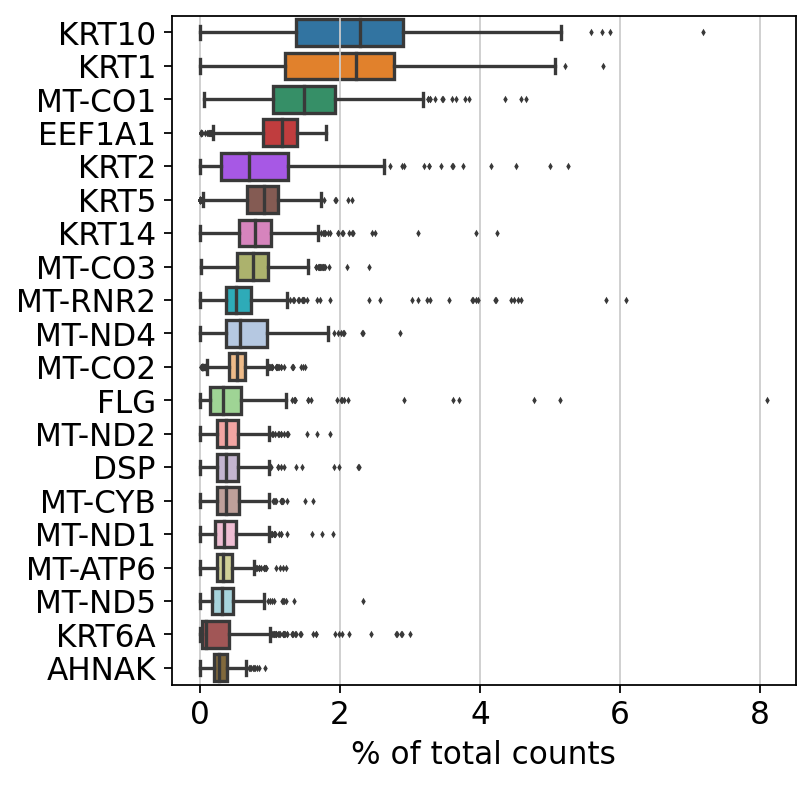

In [60]:
sc.pl.highest_expr_genes(adata, n_top=20, )


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


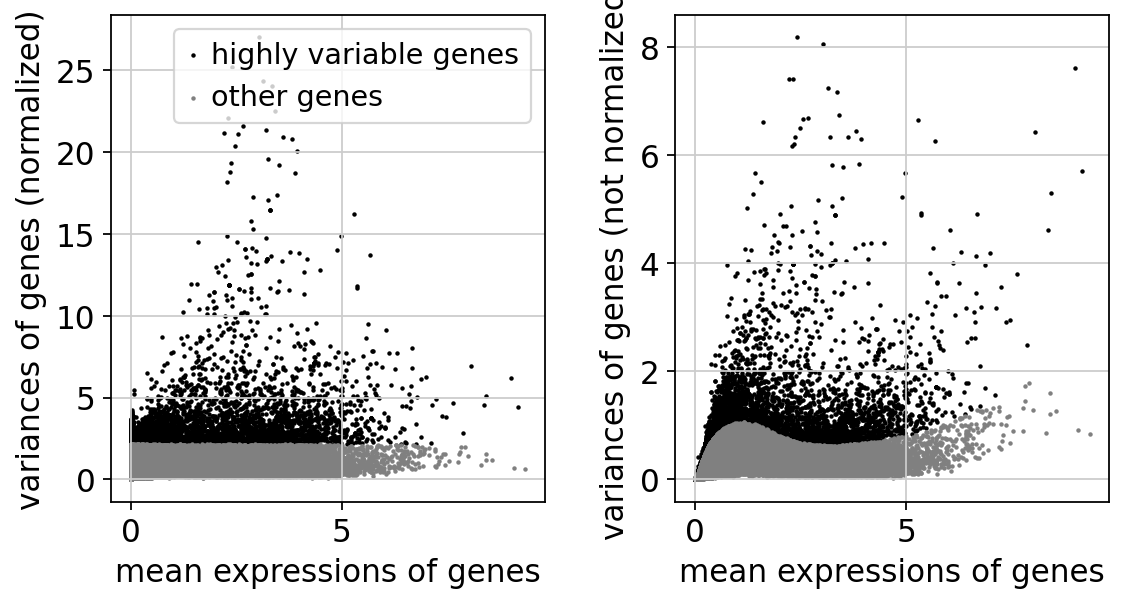

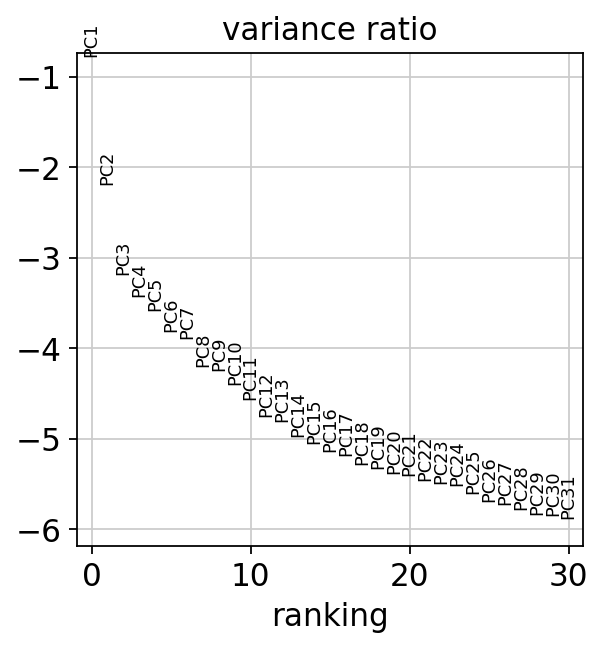

AnnData object with n_obs × n_vars = 387 × 67186
    obs: 'geo_accession', 'title', 'type', 'characteristics_ch1', 'source_name_ch1', 'sample', 'series_id', 'molecule_ch1', 'extract_protocol_ch1', 'readsaligned', 'library_selection', 'library_source', 'library_strategy', 'singlecellprobability', 'submission_date', 'data_processing', 'status', 'last_update_date', 'channel_count', 'organism_ch1', 'taxid_ch1', 'platform_id', 'instrument_model', 'relation', 'contact_name', 'contact_address', 'contact_city', 'contact_zip', 'contact_country', 'contact_institute', 'ARCHS4_idx', 'leiden'
    var: 'ensembl_gene_id', 'biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'salmon_counts', 'salmon_CPM'
    obsp: 'distances', 'connectivities'


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


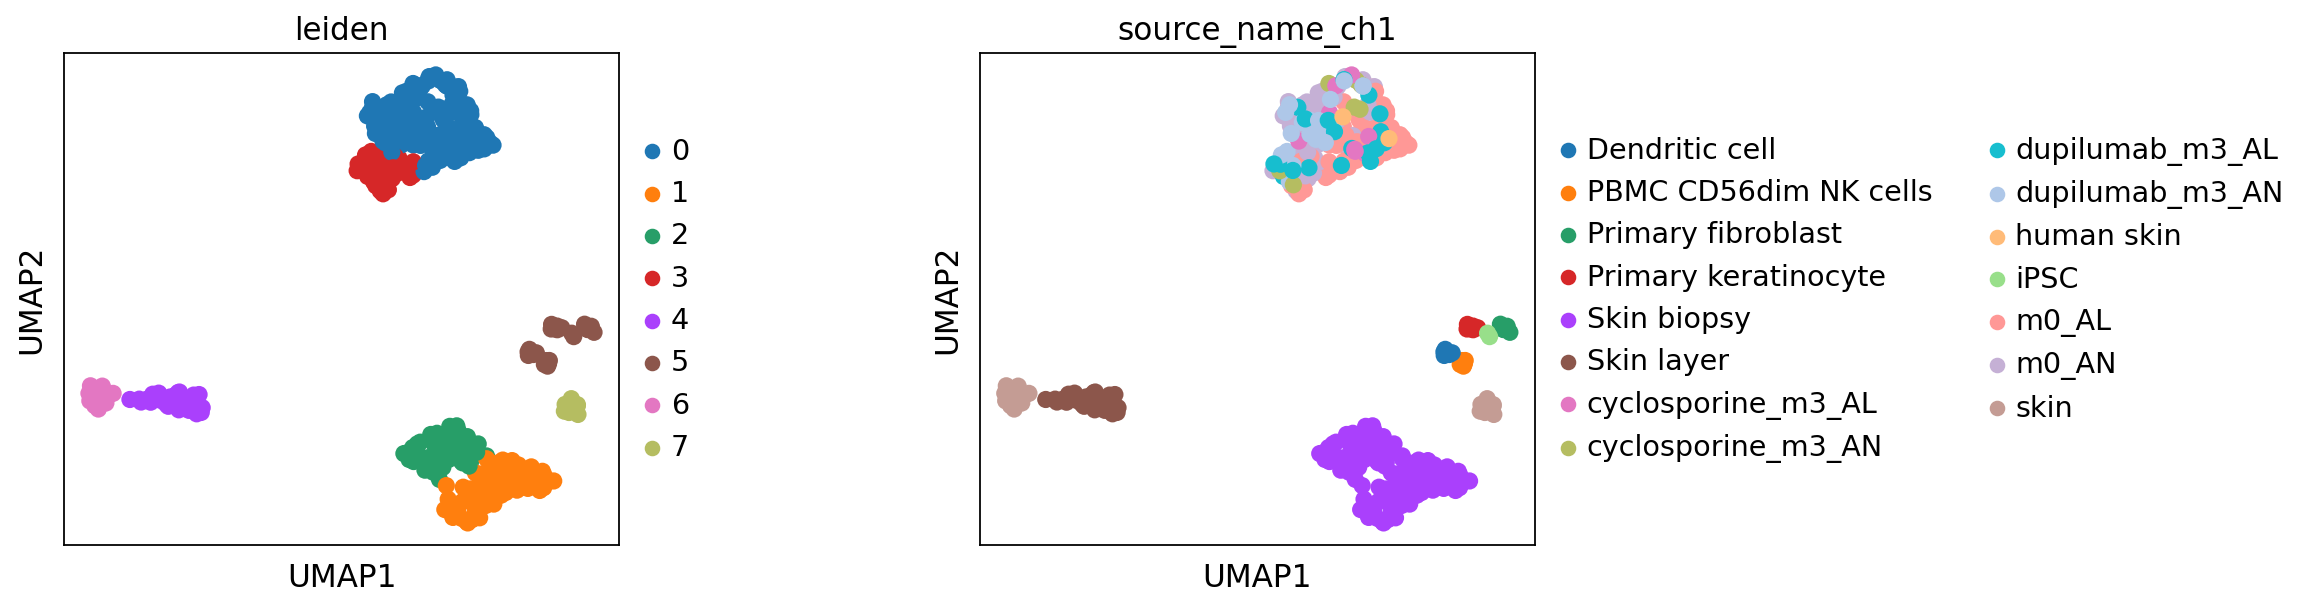

In [61]:
####    save raw counts and CPM to layers and freeze the raw data (CPMs) in .raw
adata.layers["salmon_counts"]=adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
adata.layers["salmon_CPM"]=adata.X.copy()
# set raw data to salmon_CPM ### this is the data that will be used for coloring plots
adata.raw=adata.copy()
### now log
sc.pp.log1p(adata)
###  HVG selection 
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    #subset=True,
    #layer="salmon_counts",
    flavor="seurat_v3",
)
sc.pl.highly_variable_genes(adata)
### wait dont really filter forr HVG (HVGs still marked in adata.var['highly_variable'])
#adata = adata[:, adata.var.highly_variable].copy()

sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

####### Computing the neighborhood graph
## reduce n_pcs if larger than number of samples or 50 
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=.5)
print(adata)

## some UMAP scatter plots

# Custom colormap where zero and bottom 10% values per gene are represented by grey
import matplotlib.colors as mcolors
cmap = mcolors.ListedColormap(['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                              ['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                                 list(plt.cm.viridis(np.linspace(0, 1, 90))))
sc.pl.umap(adata,
          color= ['leiden','source_name_ch1',#'characteristics_ch1'
                  ],wspace=.5,ncols=4,size=240,cmap =cmap)

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


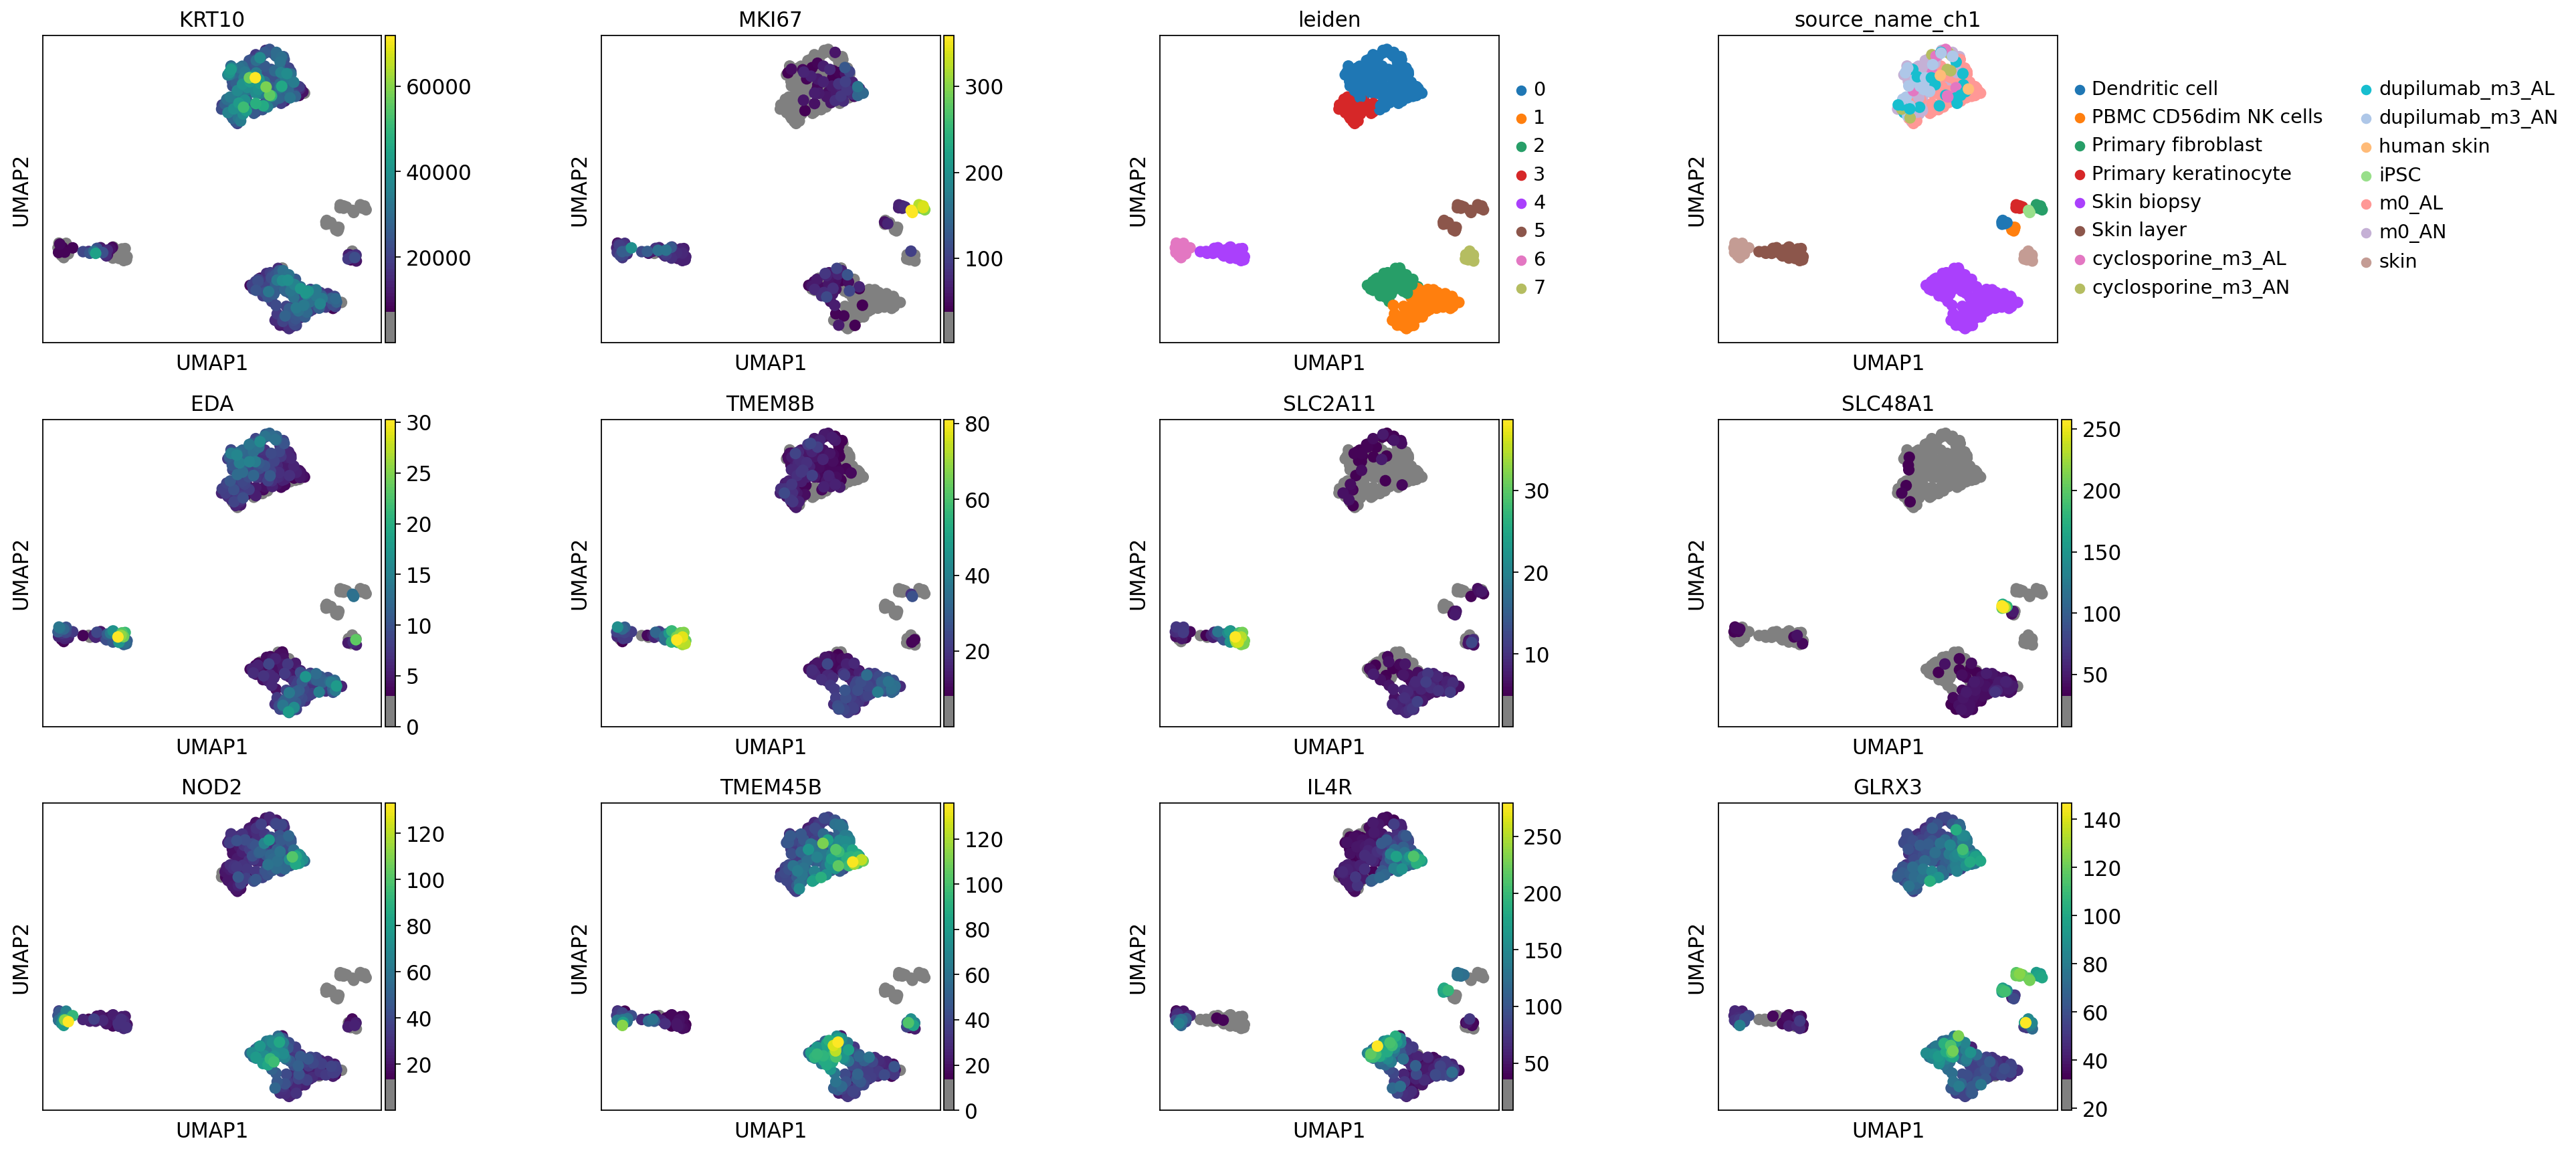

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


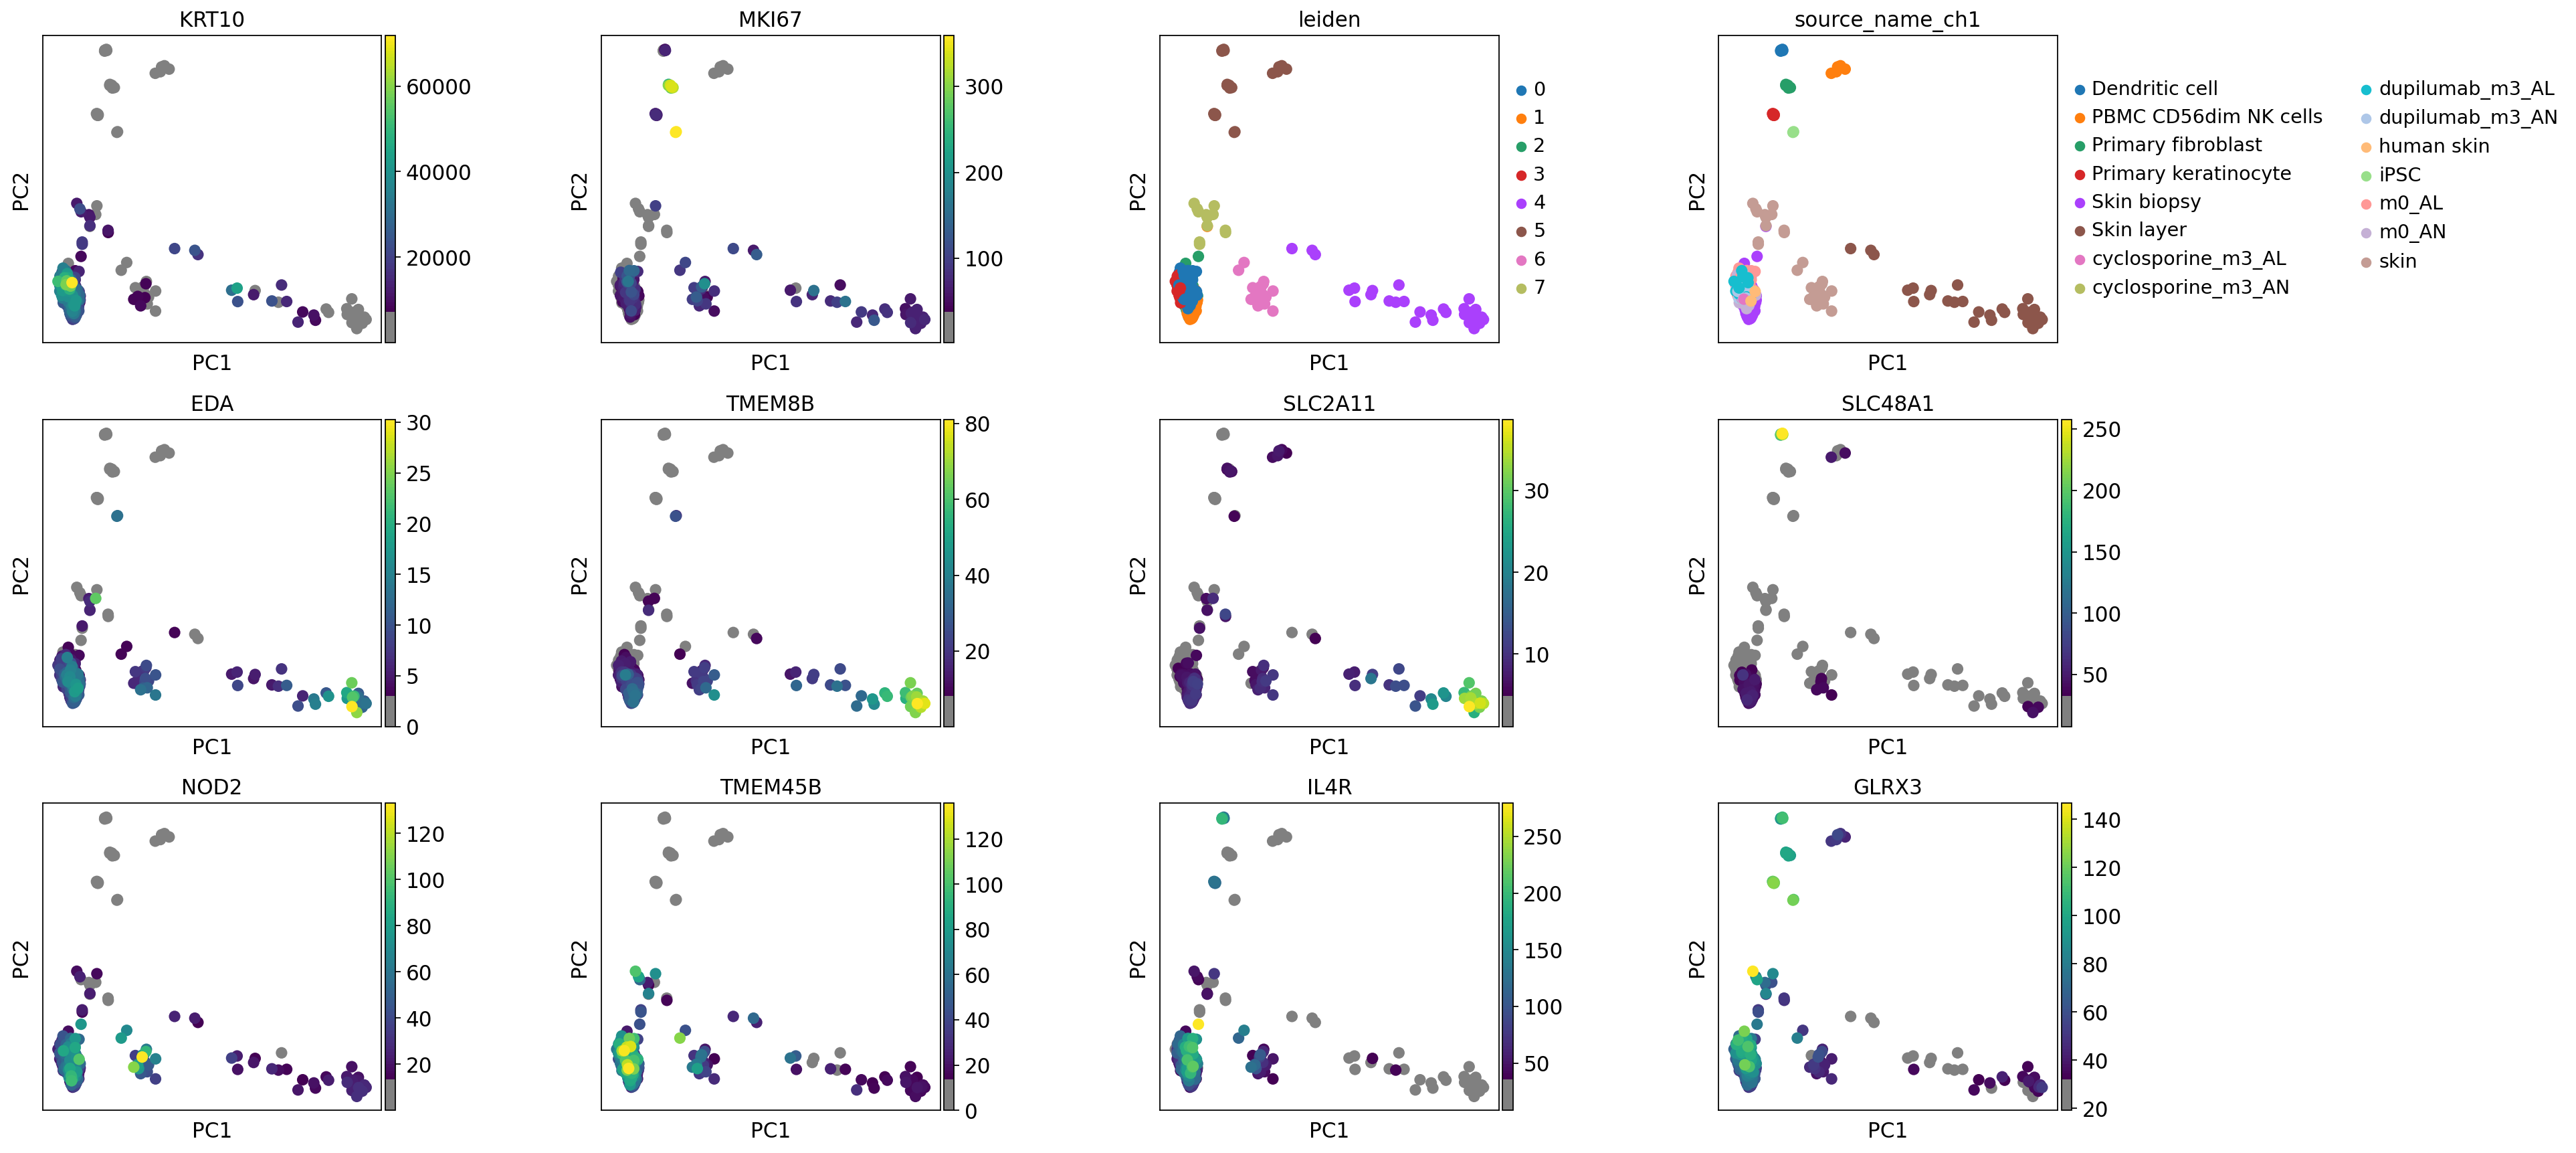

In [70]:
## some UMAP scatter plots

# Custom colormap where zero and bottom 10% values are represented by grey
import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap(['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                              ['gray'] +['gray'] +['gray'] +['gray'] +['gray']+
                                 list(plt.cm.viridis(np.linspace(0, 1, 90))))
sc.pl.umap(adata,
          color=  [ 'KRT10','MKI67','leiden','source_name_ch1',
                   'EDA','TMEM8B','SLC2A11','SLC48A1',
                 'NOD2','TMEM45B','IL4R','GLRX3',
                  ]
                  ,wspace=.5,ncols=4,size=240,cmap =cmap)

sc.pl.pca(adata,
        color=  [ 'KRT10','MKI67','leiden','source_name_ch1',
                   'EDA','TMEM8B','SLC2A11','SLC48A1',
                 'NOD2','TMEM45B','IL4R','GLRX3',
                  ],wspace=.5,ncols=4,size=240,cmap =cmap)

## now do some Differential Expression Analysis and Gene Set Enrichment Analysis based on the clusters 

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


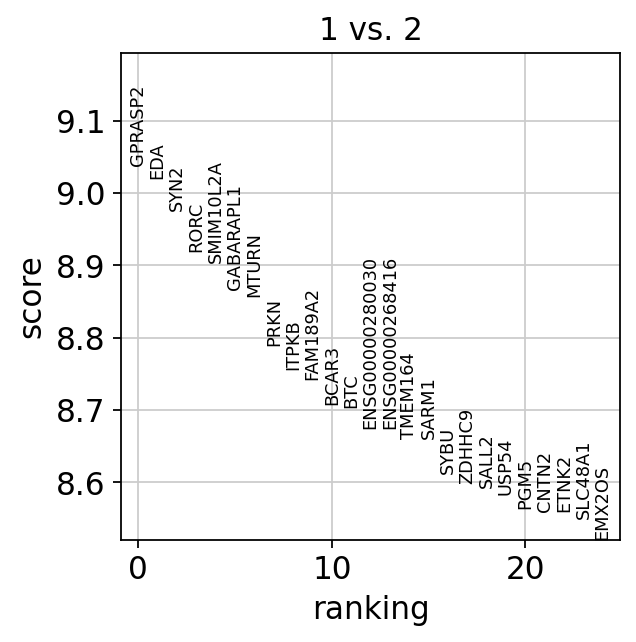

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


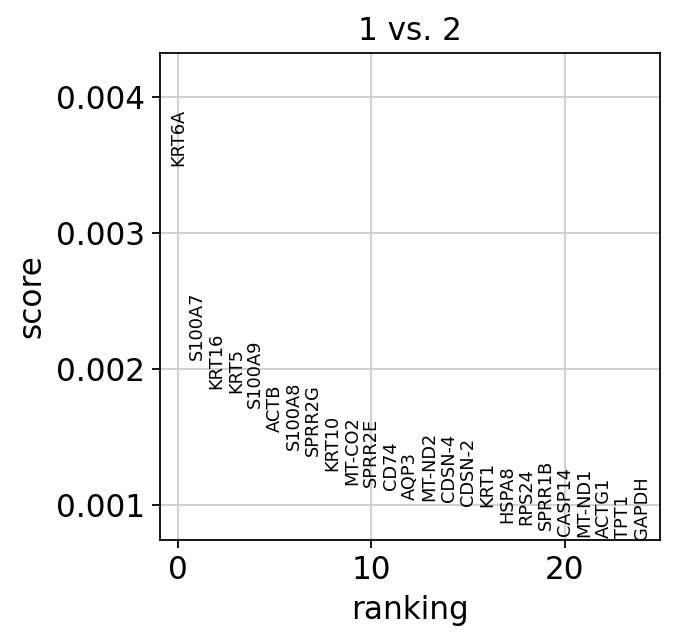

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


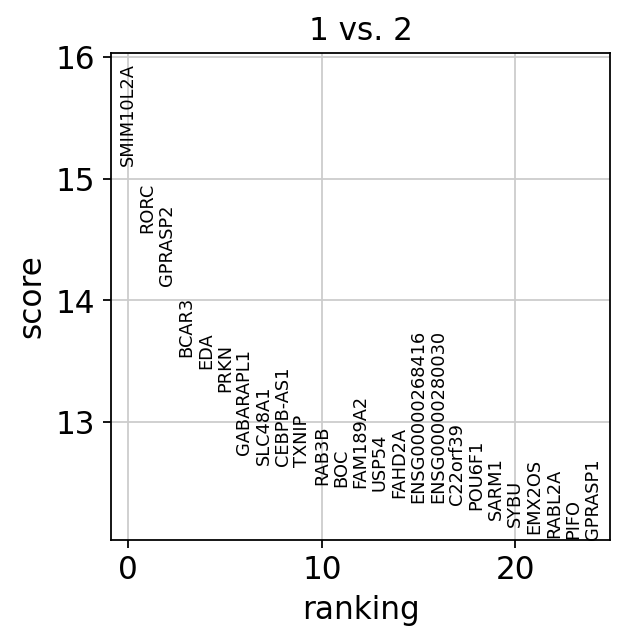

In [64]:
rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test = adsctl.tl.rank_genes_obscat1_vs_obscat2(adata,wilcox=True,logreg=True,t_test=True,rank_use_raw=True,n_jobs=1,
                                  obs_key="leiden",obscat1='1',obscat2='2',)

In [65]:
rank_genes_groups_wilcox.head(4)

1_names  1_scores       1_pvals   1_pvals_adj  1_logfoldchanges
0  GPRASP2  9.038080  1.594469e-19  1.530371e-15          7.792921
1      EDA  9.018932  1.899318e-19  1.595095e-15          7.583693
2     SYN2  8.975848  2.811775e-19  2.099021e-15          7.552614
3     RORC  8.918403  4.730622e-19  3.014941e-15         33.233944

In [66]:
rank_genes_groups_logreg.head(4)

1
0   KRT6A
1  S100A7
2   KRT16
3    KRT5

In [68]:
rank_genes_groups_t_test.head(46)

1_names   1_scores       1_pvals   1_pvals_adj  1_logfoldchanges
0         SMIM10L2A  15.109183  4.082635e-30  2.742959e-25          5.314585
1              RORC  14.556212  4.941343e-28  1.659945e-23         33.233944
2           GPRASP2  14.120816  1.185764e-27  2.655557e-23          7.792921
3             BCAR3  13.534745  2.187344e-26  3.673973e-22         13.895799
4               EDA  13.437740  1.846625e-25  2.067789e-21          7.583693
5              PRKN  13.252251  1.146221e-25  1.540200e-21          3.836313
6         GABARAPL1  12.731236  6.478963e-24  4.836618e-20         40.647835
7           SLC48A1  12.650235  1.026861e-23  6.271879e-20         21.018995
8         CEBPB-AS1  12.637093  4.389677e-24  4.213212e-20          1.998234
9             TXNIP  12.633702  5.484205e-24  4.605773e-20               inf
10            RAB3B  12.485513  5.150871e-22  1.234205e-18         10.976629
11              BOC  12.464353  9.195649e-24  6.178189e-20         56.329296
12         FAM189A2  12.463020  1.735038e-23  8.966945e-20         22.274572
13            USP54  12.436934  1.723549e-23  8.966945e-20         32.900425
14           FAHD2A  12.376955  3.104607e-23  1.390574e-19         13.575879
15  ENSG00000268416  12.333727  5.396595e-22  1.234205e-18          9.840683
16  ENSG00000280030  12.333727  5.396595e-22  1.234205e-18          9.840683
17         C22orf39  12.320724  3.964312e-23  1.664664e-19         11.894425
18           POU6F1  12.275750  2.538455e-23  1.218205e-19         15.521722
19            SARM1  12.198786  4.612343e-23  1.822852e-19         11.752258
20             SYBU  12.139659  5.914769e-23  2.207720e-19         10.540919
21           EMX2OS  12.083401  7.722354e-23  2.730706e-19         19.212738
22           RABL2A  12.049079  7.679535e-22  1.664378e-18         13.756019
23             PIFO  12.035930  1.712938e-22  5.231157e-19          2.220892
24          GPRASP1  12.033954  1.241829e-22  3.973024e-19          8.247896
25           TMEM8B  12.030420  1.037343e-22  3.484745e-19         15.263893
26           TRIM45  11.922420  2.034031e-22  5.941669e-19          6.905943
27          TMEM108  11.867845  2.148807e-21  4.010272e-18          2.908323
28         ARHGAP44  11.844286  4.357444e-22  1.171037e-18          3.642706
29            JADE1  11.828578  3.186094e-22  8.919206e-19         16.735779
30            CGNL1  11.773187  5.510992e-22  1.234205e-18         35.914017
31       ZNF528-AS1  11.755287  5.106800e-22  1.234205e-18          4.554572
32              BTC  11.752229  1.365084e-20  2.084421e-17         28.966255
33             PGM5  11.728632  1.790366e-21  3.436787e-18         25.159647
34            SALL2  11.673388  1.168050e-21  2.378078e-18          5.825975
35            SNTB1  11.631606  1.122191e-21  2.356109e-18         18.396719
36         C1orf115  11.590284  9.002652e-21  1.475249e-17         25.927868
37            GPLD1  11.540938  1.635509e-21  3.231863e-18         14.718163
38            AGBL4  11.498681  4.212874e-20  4.965721e-17          2.165124
39             COG1  11.478854  3.604851e-20  4.485102e-17         16.371164
40          SLC2A11  11.450713  3.153202e-21  5.725704e-18          4.286601
41             SCIN  11.433252  9.568211e-21  1.530595e-17          7.151249
42           ZDHHC9  11.422601  7.997659e-21  1.343327e-17         66.028221
43         CACNA2D2  11.408007  2.967875e-20  3.863280e-17          6.218253
44            NPTXR  11.396838  1.151114e-20  1.798575e-17          4.799110
45            CNTN2  11.324520  2.990065e-20  3.863280e-17          4.238632

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


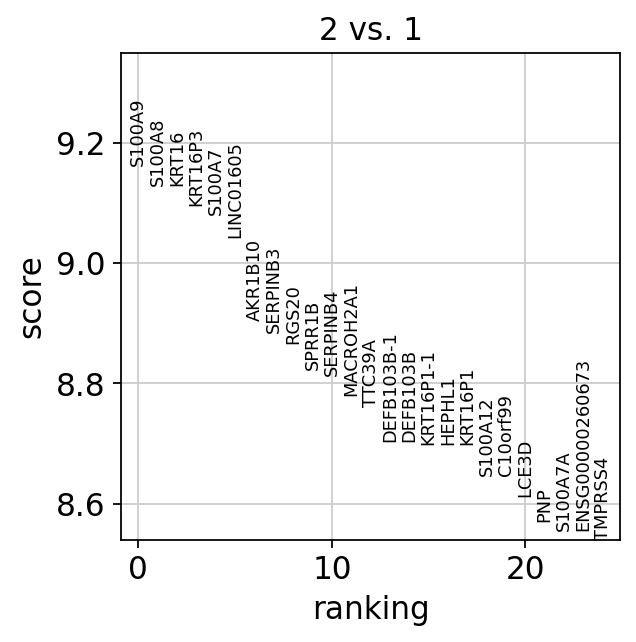

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


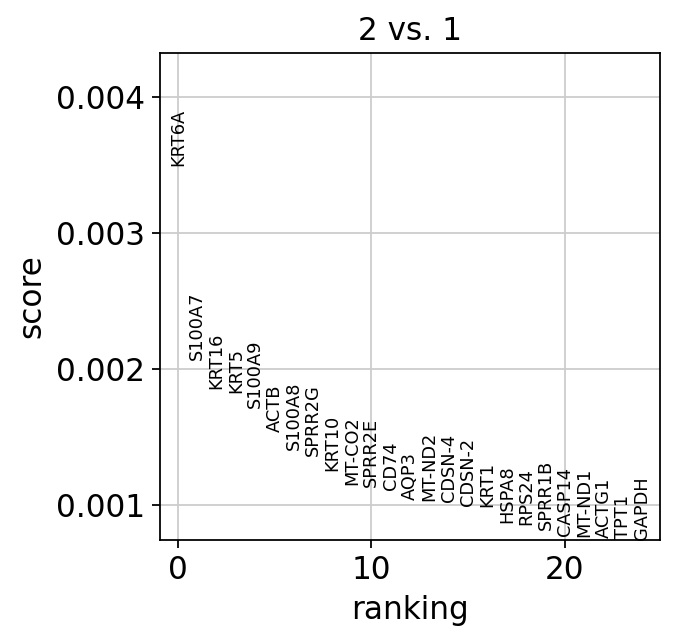

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


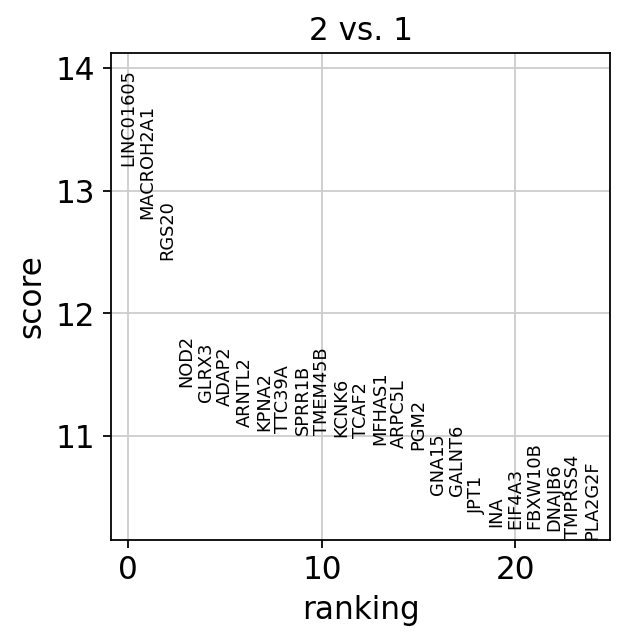

2_names   2_scores       2_pvals   2_pvals_adj  2_logfoldchanges
0         LINC01605  13.207436  2.636656e-19  2.393870e-16          8.885972
1         MACROH2A1  12.772955  1.826544e-20  2.727070e-17         93.878937
2             RGS20  12.439625  8.147560e-20  8.829064e-17          9.711171
3              NOD2  11.402142  5.918387e-18  3.823392e-15         41.143963
4             GLRX3  11.277881  7.161102e-18  4.538922e-15         38.956154
5             ADAP2  11.243218  8.551318e-18  5.255563e-15         34.900898
6            ARNTL2  11.073648  5.204212e-17  2.378573e-14         52.147072
7             KPNA2  11.042044  2.647285e-17  1.371417e-14         58.905724
8            TTC39A  11.024632  1.572134e-16  6.141011e-14         45.369728
9            SPRR1B  11.012141  8.716858e-16  2.723957e-13               inf
10          TMEM45B  11.004907  8.169217e-17  3.483715e-14         57.202106
11            KCNK6  10.990234  2.461535e-17  1.302210e-14        105.979469
12            TCAF2  10.983907  6.340414e-17  2.839914e-14         20.091158
13           MFHAS1  10.924063  5.010323e-17  2.305641e-14         35.359367
14           ARPC5L  10.902587  9.169802e-18  5.500735e-15         43.951809
15             PGM2  10.885900  2.975100e-17  1.500586e-14         57.576748
16            GNA15  10.516900  2.761655e-16  1.036562e-13         55.446159
17           GALNT6  10.510313  1.167322e-16  4.696271e-14         54.316799
18             JPT1  10.360264  2.969069e-17  1.500586e-14         24.801813
19              INA  10.261128  2.589080e-15  6.930276e-13          8.371083
20           EIF4A3  10.242295  1.683884e-15  4.834763e-13         61.340618
21          FBXW10B  10.239070  3.209010e-15  8.166688e-13          8.518216
22           DNAJB6  10.226866  3.342381e-16  1.220441e-13        103.875122
23          TMPRSS4  10.166323  9.018029e-15  2.006243e-12         50.529083
24          PLA2G2F  10.153947  2.122629e-15  5.797193e-13         96.350021
25            TUBB6  10.153638  1.465133e-15  4.336405e-13        115.391724
26            NCAPH  10.149944  2.260736e-15  6.099992e-13          8.442348
27             RCC1  10.128180  3.454821e-16  1.247933e-13         18.910570
28        SERPINB13  10.041141  3.566578e-14  6.674766e-12        133.219696
29           ACTR3C  10.026710  4.912899e-17  2.276400e-14          2.156583
30            PLBD1  10.018191  6.595977e-16  2.204763e-13         76.235176
31           DUOXA1   9.987465  8.406587e-15  1.895319e-12        145.272263
32  ENSG00000251455   9.963450  7.941032e-16  2.504818e-13          2.484212
33          FAM110C   9.891409  1.031726e-14  2.257901e-12         25.055962
34          AKR1B10   9.872212  7.546996e-14  1.270808e-11         63.634148
35              RAN   9.652845  8.480917e-15  1.905682e-12        137.206909
36             HPSE   9.617470  9.512030e-14  1.573760e-11         35.046059
37           FLVCR2   9.555350  2.281759e-14  4.617538e-12         12.836472
38            CCNB1   9.524780  4.865695e-14  8.765593e-12         25.496597
39             MELK   9.523882  8.534456e-14  1.422819e-11         10.439997
40             DBNL   9.446047  4.711532e-15  1.142776e-12         53.625683
41           ALYREF   9.437911  1.246174e-14  2.683508e-12         16.959394
42             IL4R   9.432605  8.290635e-14  1.385608e-11        100.481995
43             RRM2   9.425483  1.361721e-13  2.137583e-11         31.847790
44           EIF4A1   9.409823  1.412457e-14  3.003080e-12               inf
45              BLM   9.399051  5.526108e-14  9.719295e-12          3.612334

In [71]:
rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test = adsctl.tl.rank_genes_obscat1_vs_obscat2(adata,wilcox=True,logreg=True,t_test=True,rank_use_raw=True,n_jobs=1,
                                  obs_key="leiden",obscat1='2',obscat2='1',)
rank_genes_groups_t_test.head(46)

#### now do a comparison dif expression for all the clusters vs the rest

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (sel

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/__init__.py:397: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


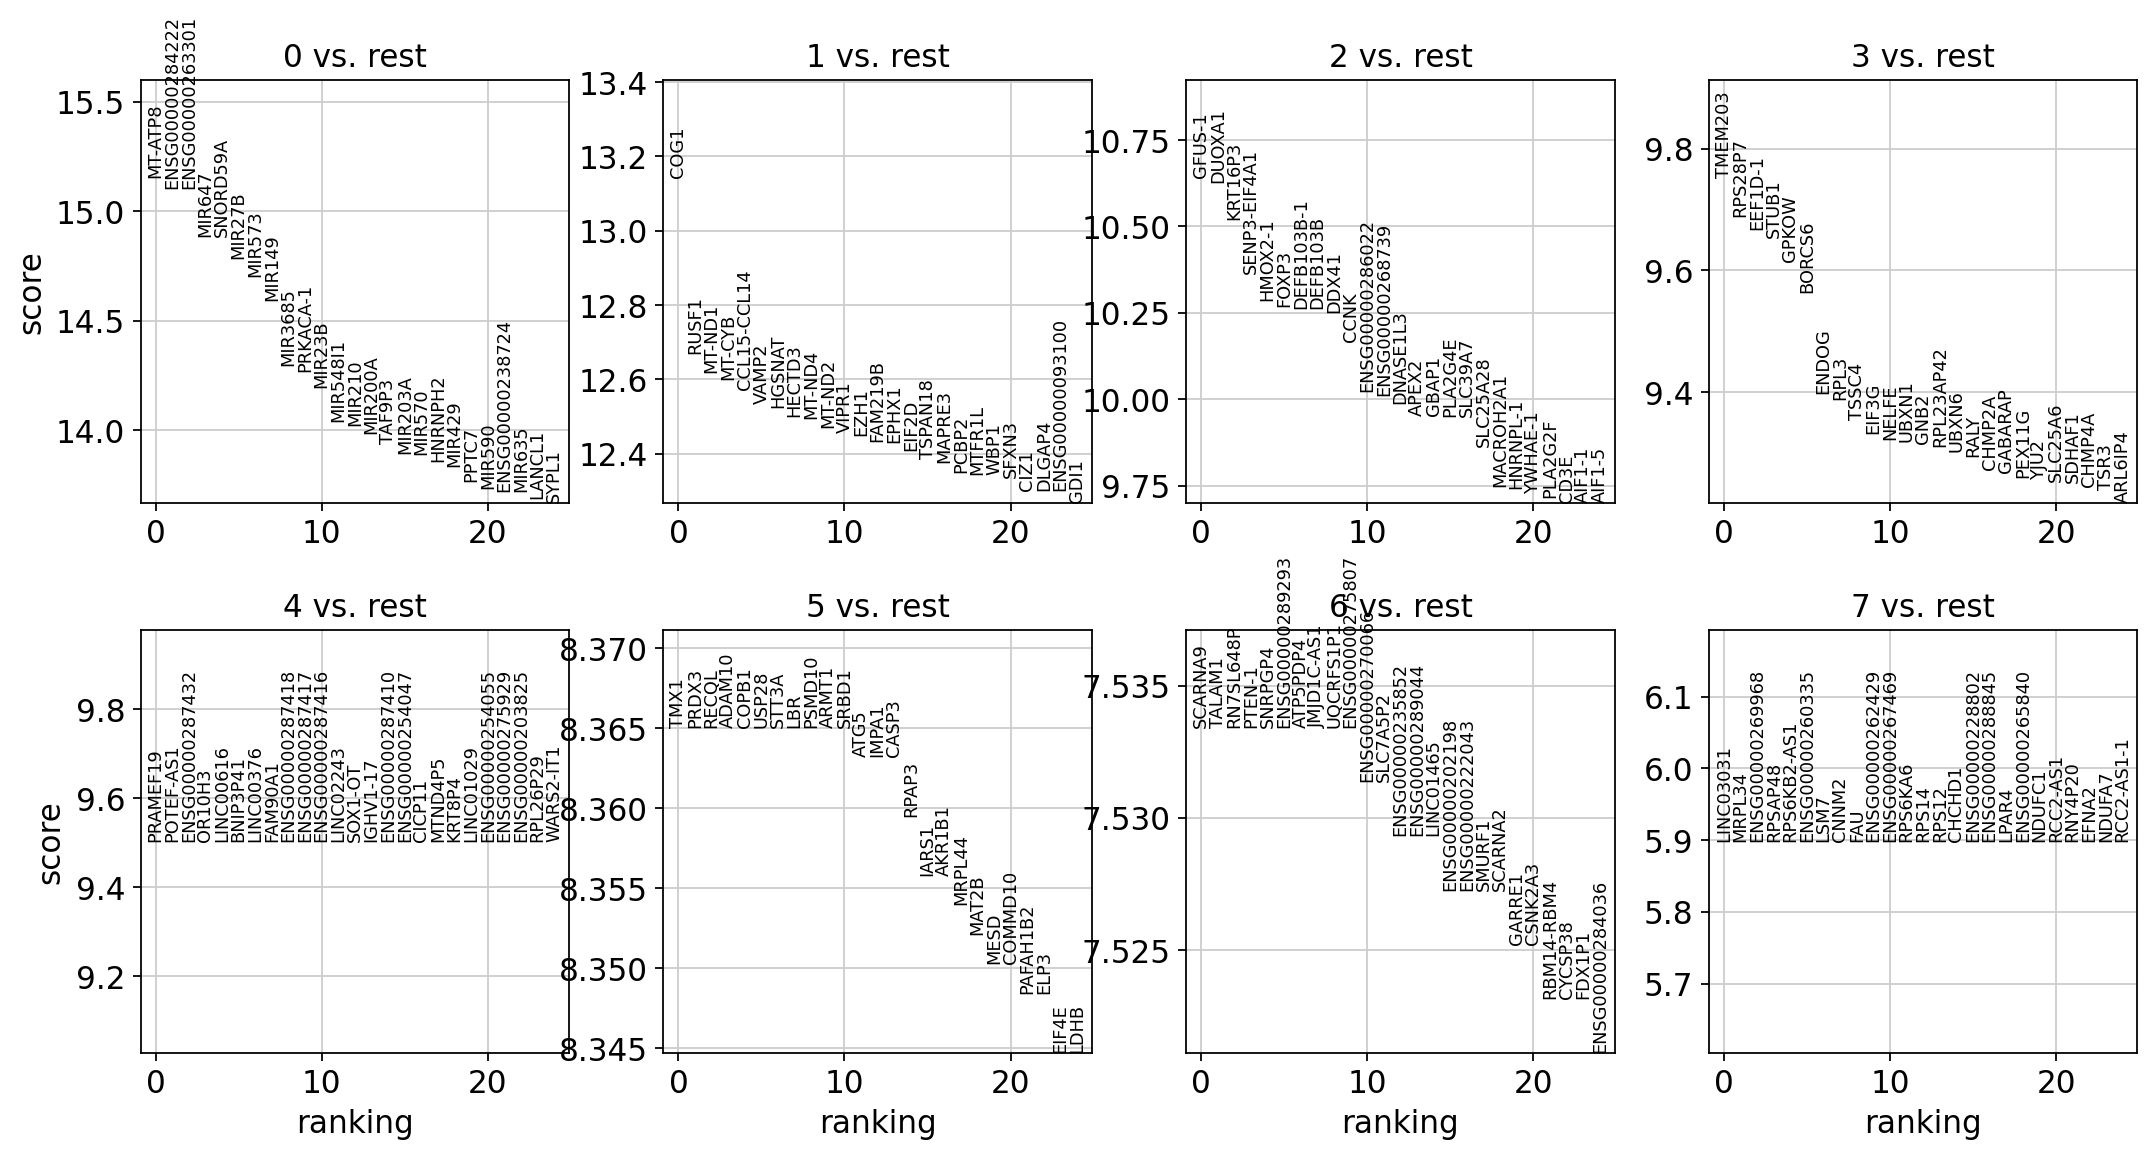

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


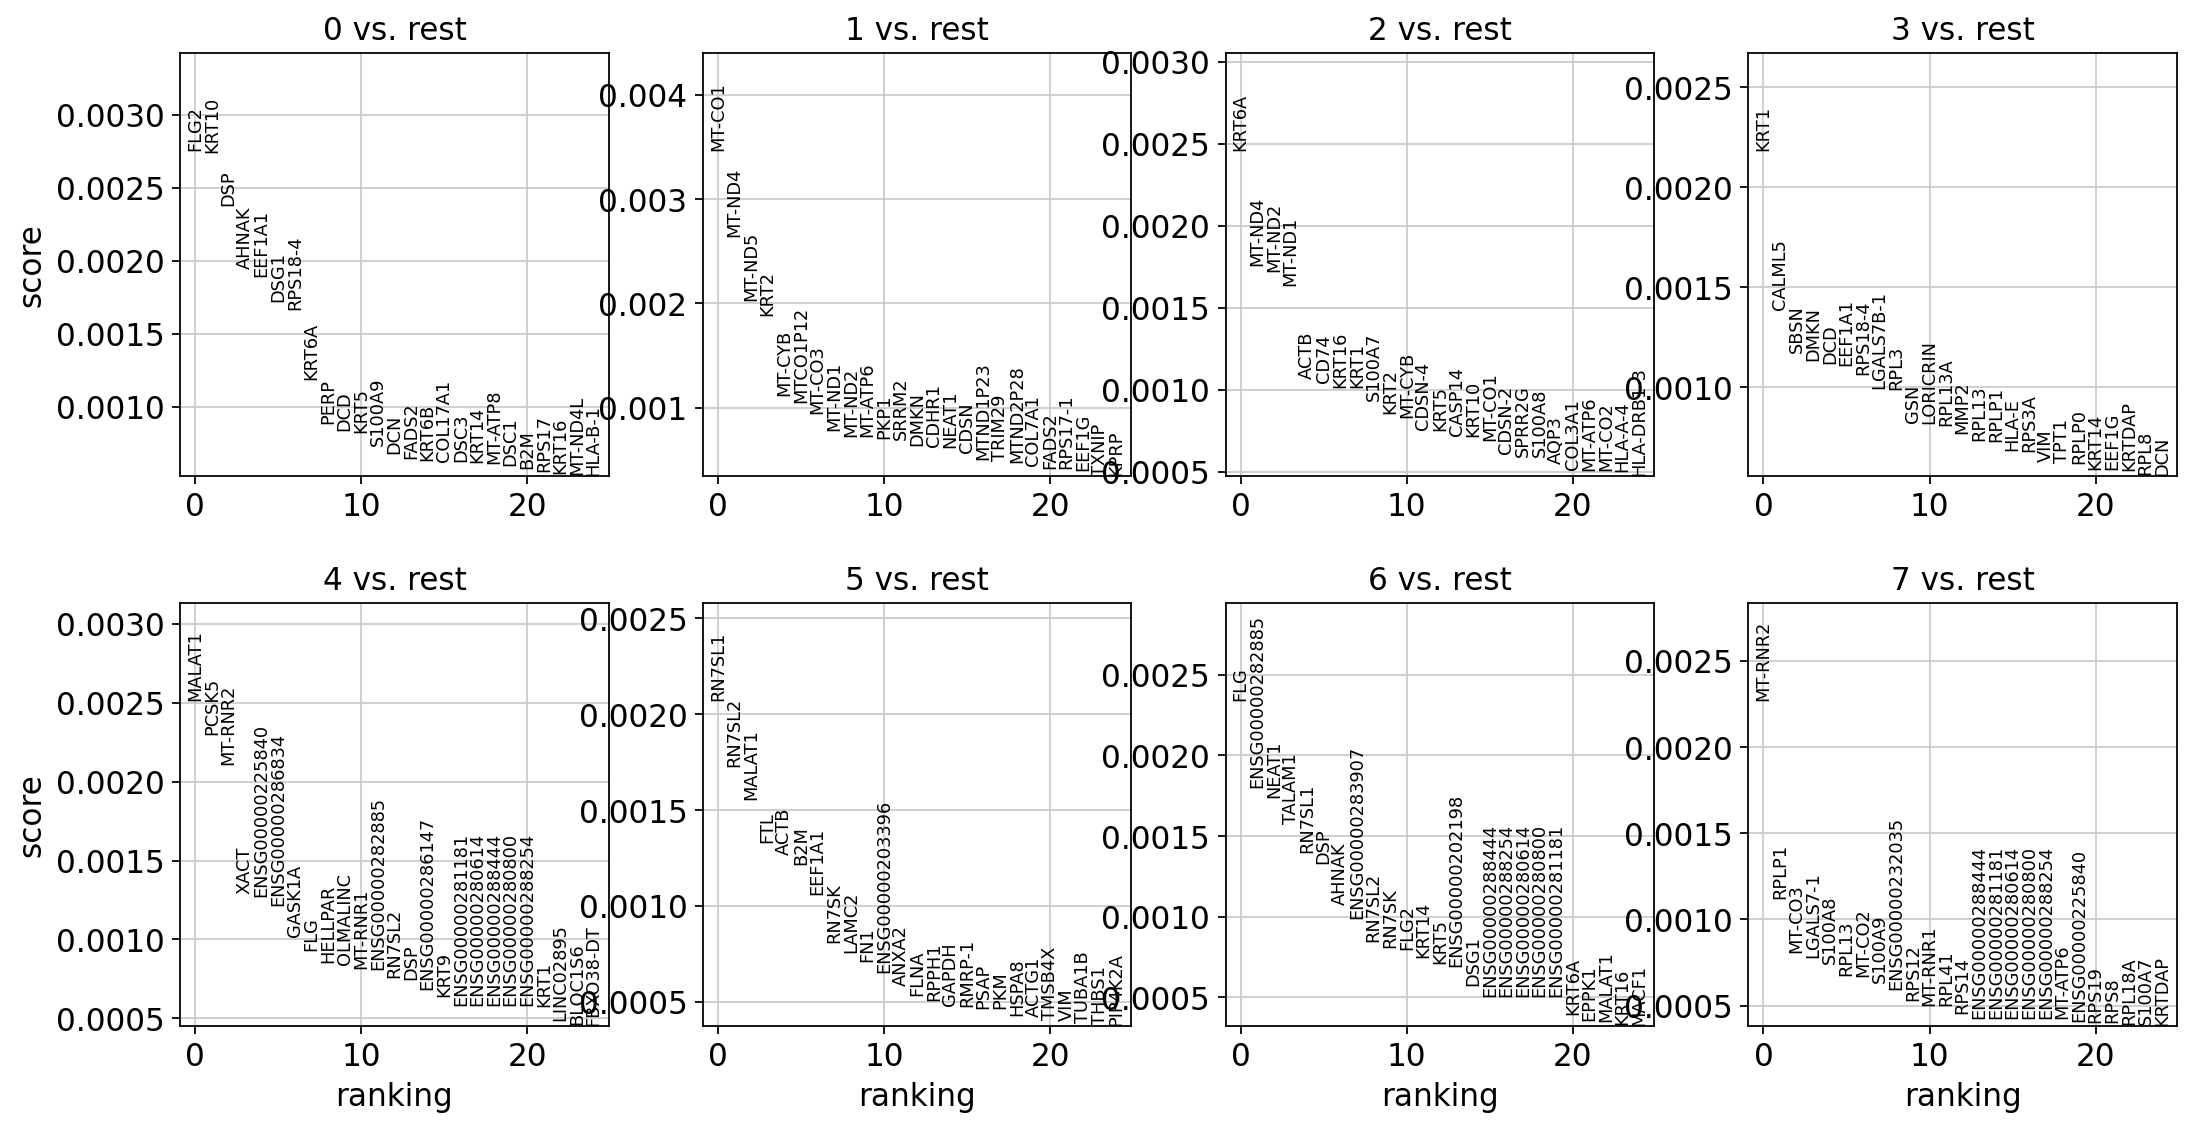

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (sel

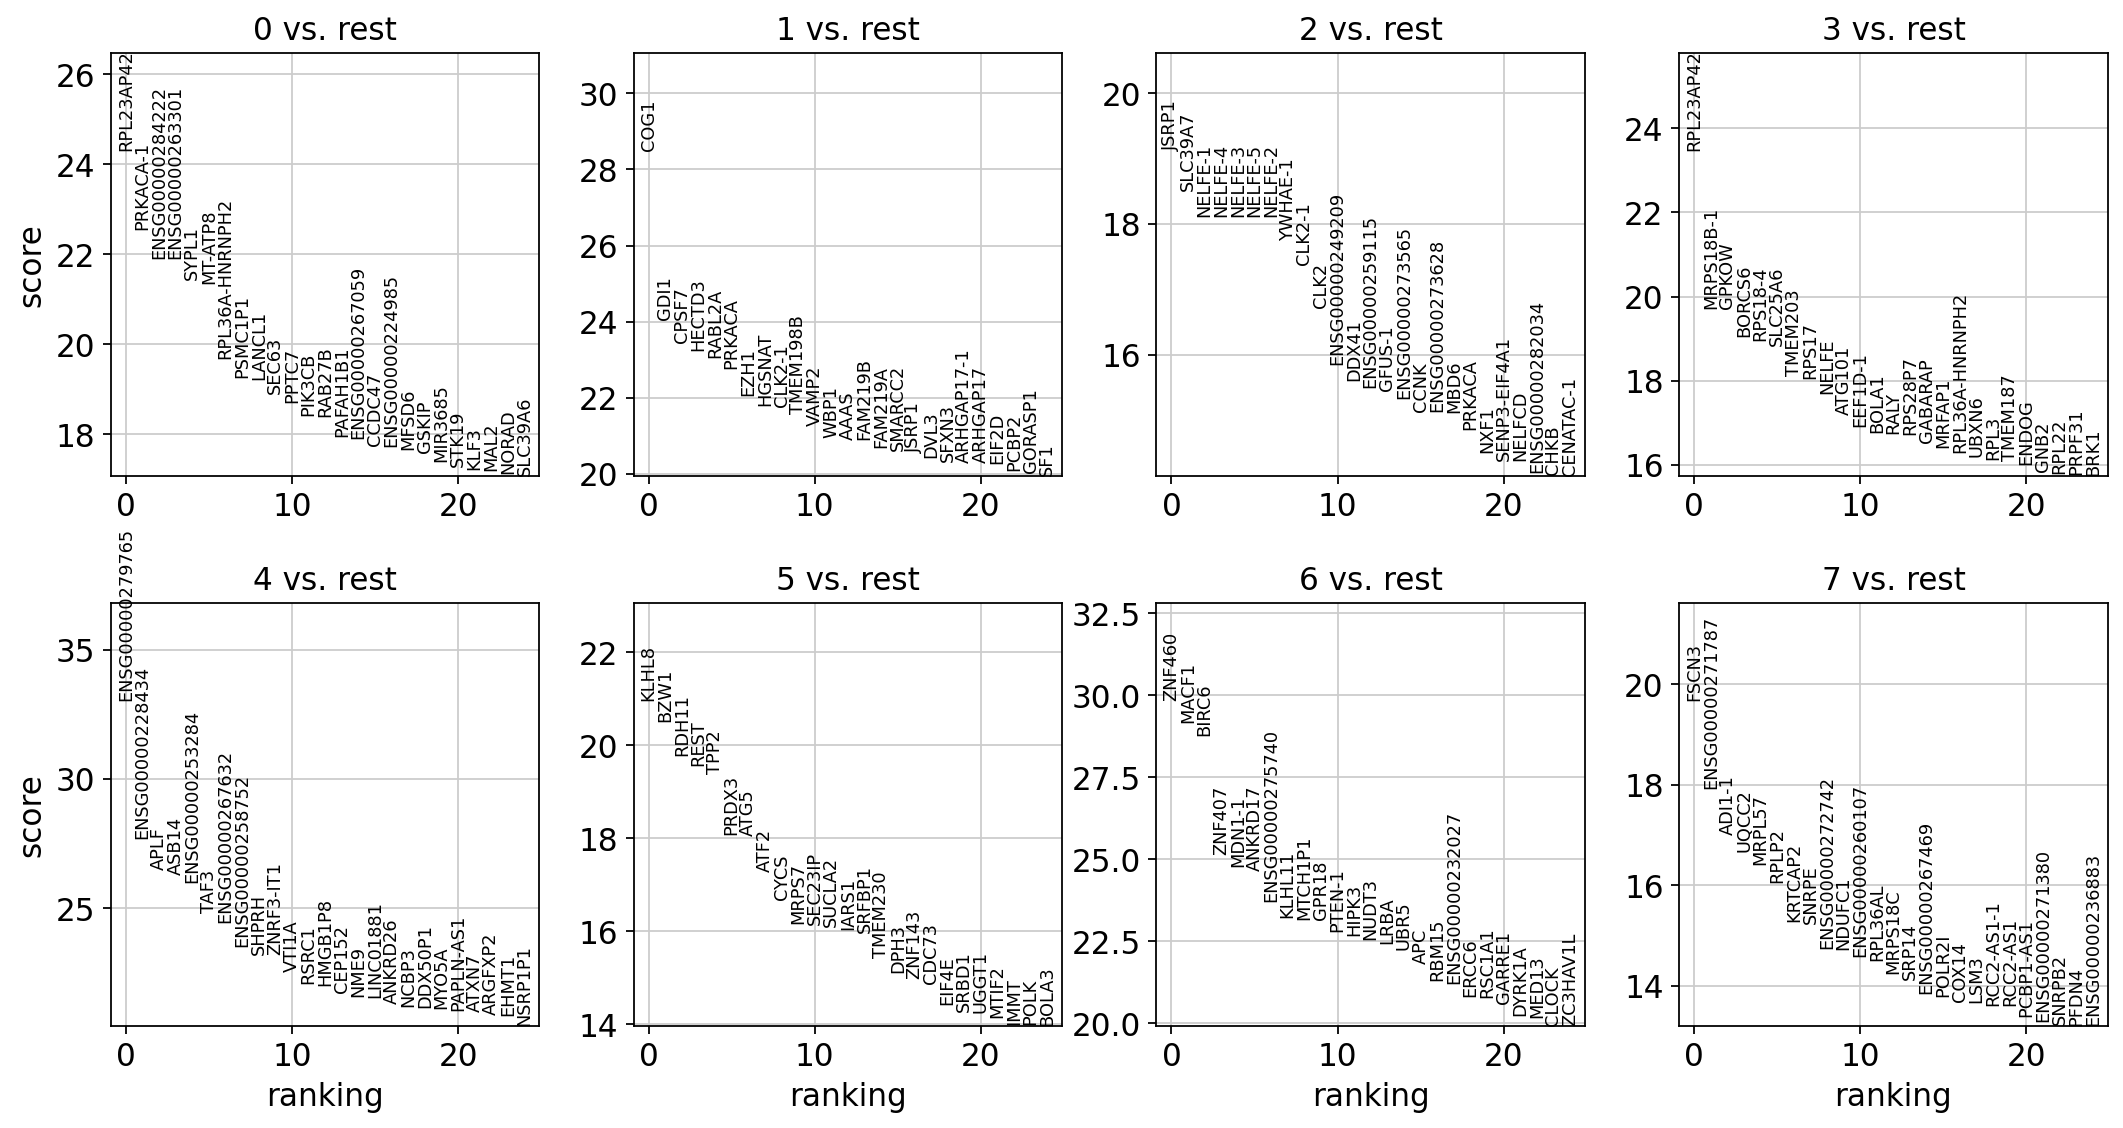

In [72]:
rank_genes_groups_wilcox, rank_genes_groups_logreg,rank_genes_groups_t_test = adsctl.tl.rank_genes(adata,
               wilcox=True,logreg=True,t_test=True,rank_use_raw=True,obs_key="leiden",
                 )

In [73]:
rank_genes_groups_wilcox.head(4)

0_names   0_scores       0_pvals   0_pvals_adj  0_logfoldchanges 1_names   1_scores       1_pvals   1_pvals_adj  1_logfoldchanges       2_names   2_scores       2_pvals   2_pvals_adj  2_logfoldchanges  3_names  3_scores       3_pvals   3_pvals_adj  3_logfoldchanges          4_names  4_scores       4_pvals   4_pvals_adj  4_logfoldchanges 5_names  5_scores       5_pvals   5_pvals_adj  5_logfoldchanges    6_names  6_scores       6_pvals   6_pvals_adj  6_logfoldchanges          7_names  7_scores       7_pvals   7_pvals_adj  7_logfoldchanges
0          MT-ATP8  15.154778  7.045324e-52  3.414397e-47        545.067078    COG1  13.143402  1.856864e-39  1.247553e-34         31.597815        GFUS-1  10.641759  1.904986e-26  7.586289e-22         92.300331  TMEM203  9.752967  1.791544e-22  7.909243e-18         30.031172         PRAMEF19  9.503933  2.021093e-21  2.429904e-20         12.764321    TMX1   8.36506  6.008440e-17  1.269918e-14        132.357773    SCARNA9  7.533431  4.942427e-14  3.723154e-11         44.895973        LINC03031  5.898628  3.665362e-09  6.171821e-07               inf
1  ENSG00000284222  15.103974  1.524602e-51  3.414397e-47          2.876839   RUSF1  12.670972  8.564670e-37  2.877129e-32         56.581936        DUOXA1  10.625897  2.258294e-26  7.586289e-22        184.111099  RPS28P7  9.688823  3.363820e-22  7.909243e-18        125.484230        POTEF-AS1  9.503933  2.021093e-21  2.429904e-20         27.178686   PRDX3   8.36506  6.008440e-17  1.269918e-14        253.578064     TALAM1  7.533431  4.942427e-14  3.723154e-11               inf           MRPL34  5.898628  3.665362e-09  6.171821e-07         64.359833
2  ENSG00000263301  15.103974  1.524602e-51  3.414397e-47          2.876839  MT-ND1  12.618353  1.672844e-36  3.493205e-32               NaN       KRT16P3  10.518832  7.074497e-26  1.584357e-21         46.707558  EEF1D-1  9.666921  4.167291e-22  7.909243e-18        159.696671  ENSG00000287432  9.503933  2.021093e-21  2.429904e-20         14.826304   RECQL   8.36506  6.008440e-17  1.269918e-14        131.361282  RN7SL648P  7.533431  4.942427e-14  3.723154e-11          8.869667  ENSG00000269968  5.898628  3.665362e-09  6.171821e-07        852.433533
3           MIR647  14.886861  4.011647e-50  4.723192e-46          3.928055  MT-CYB  12.601194  2.079722e-36  3.493205e-32               NaN  SENP3-EIF4A1  10.362861  3.658538e-25  6.145063e-21         35.037048    STUB1  9.654405  4.708864e-22  7.909243e-18         88.659691           OR10H3  9.503933  2.021093e-21  2.429904e-20         17.986526  ADAM10   8.36506  6.008440e-17  1.269918e-14        296.432800     PTEN-1  7.533431  4.942427e-14  3.723154e-11        122.218987          RPSAP48  5.898628  3.665362e-09  6.171821e-07        168.490280

In [74]:
rank_genes_groups_logreg.head(4)

0       1       2       3        4       5                6         7
0   FLG2  MT-CO1   KRT6A    KRT1   MALAT1  RN7SL1              FLG   MT-RNR2
1  KRT10  MT-ND4  MT-ND4  CALML5    PCSK5  RN7SL2  ENSG00000282885     RPLP1
2    DSP  MT-ND5  MT-ND2    SBSN  MT-RNR2  MALAT1            NEAT1    MT-CO3
3  AHNAK    KRT2  MT-ND1    DMKN     XACT     FTL           TALAM1  LGALS7-1

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


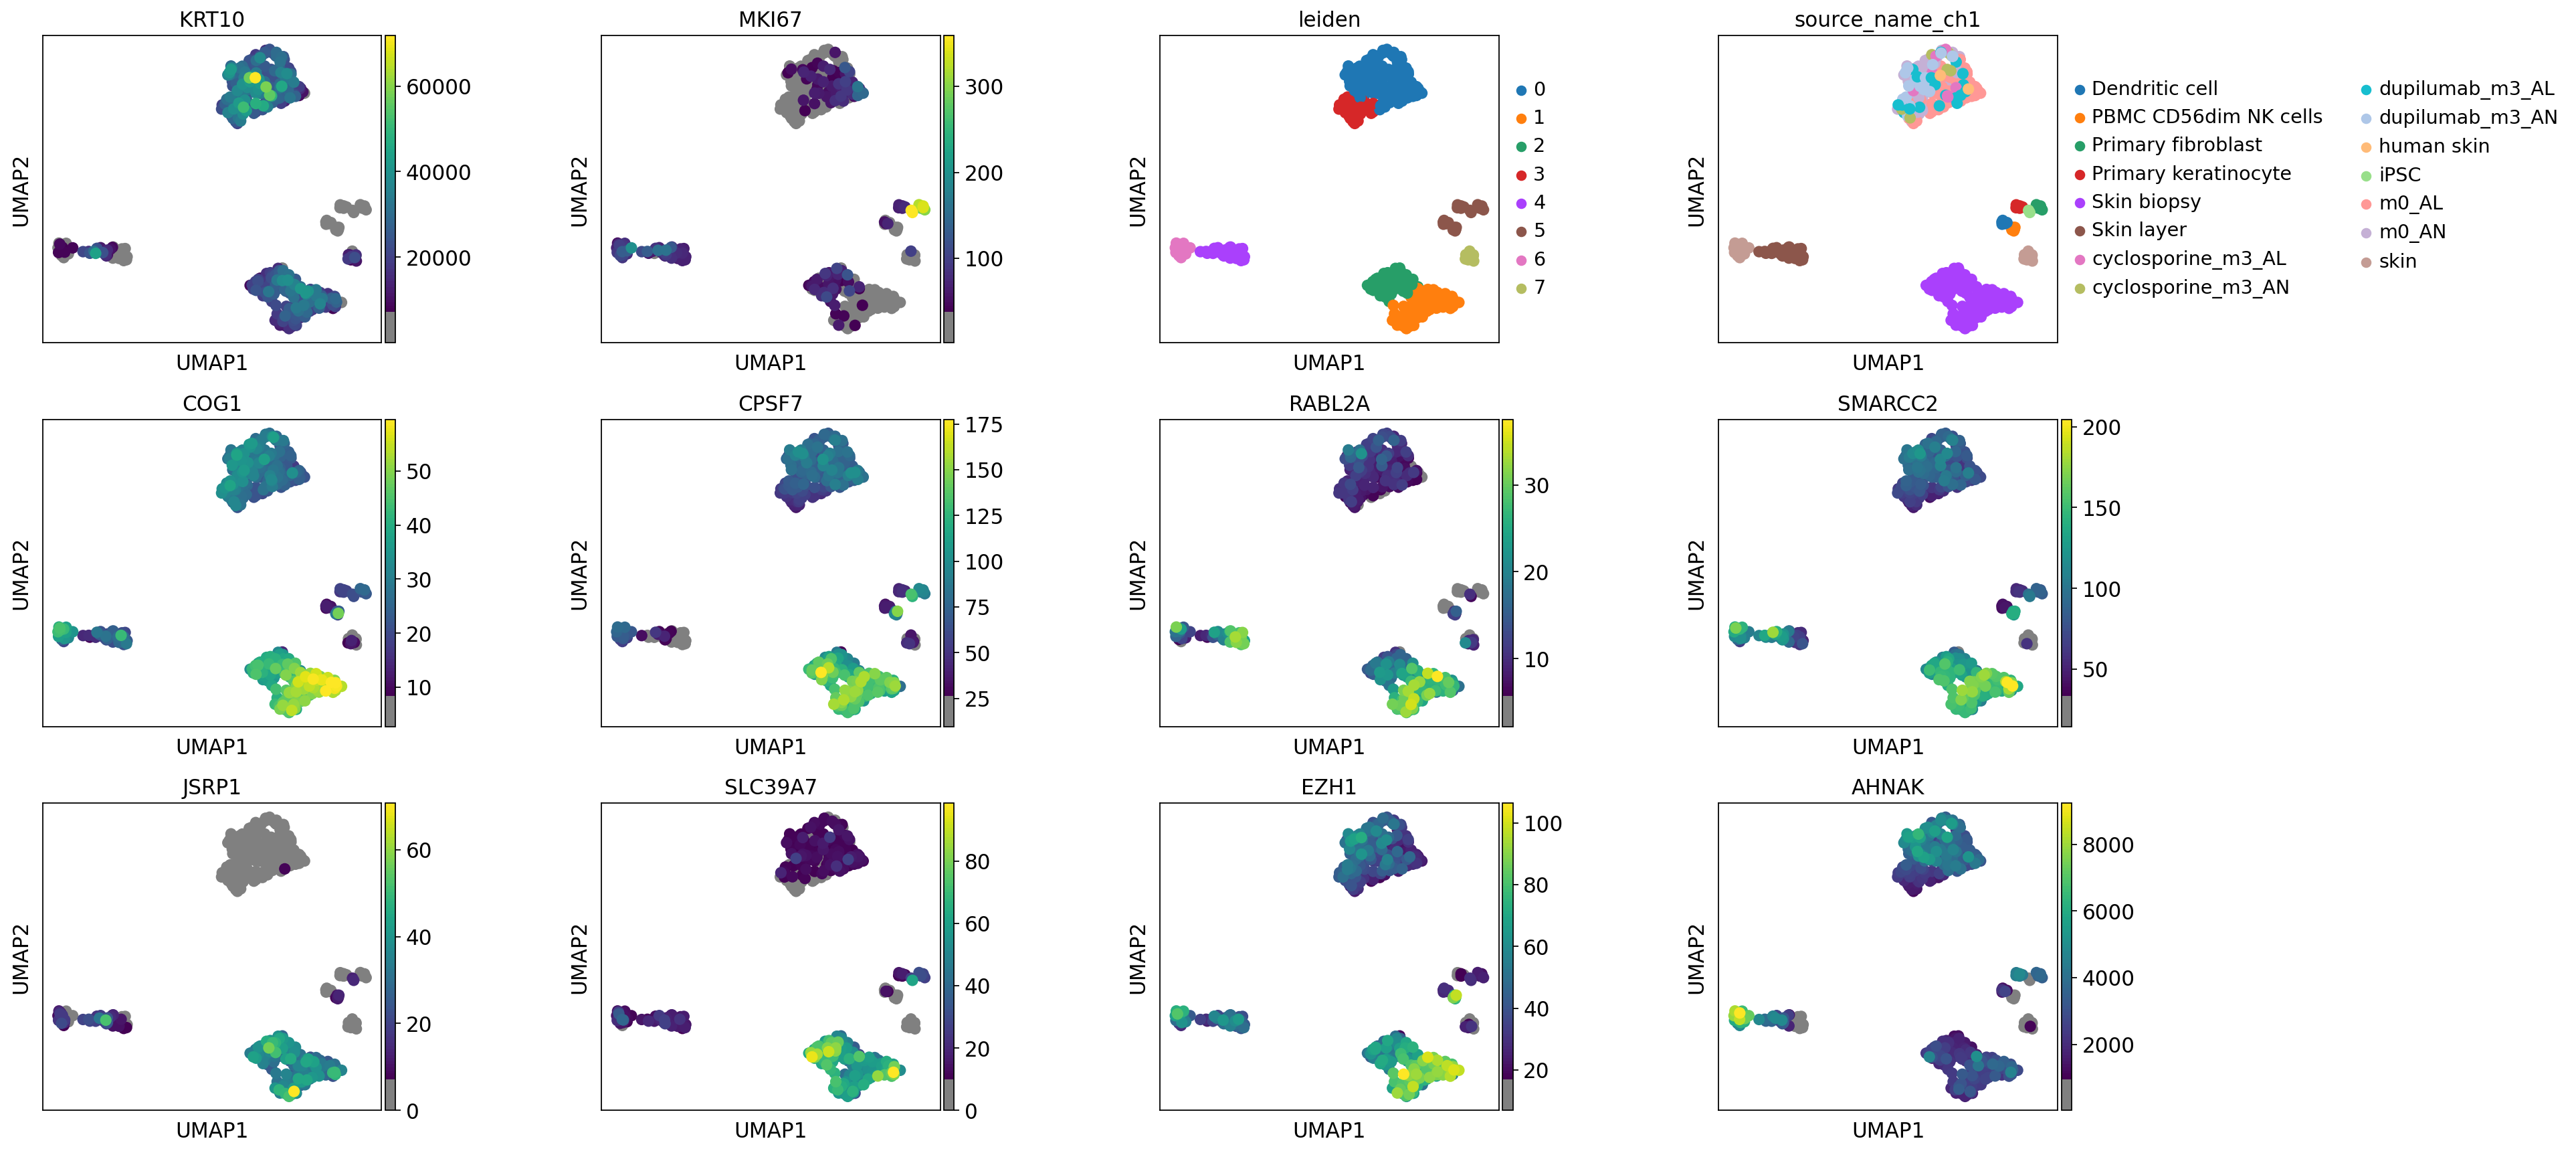

In [75]:
sc.pl.umap(adata,
          color= [ 'KRT10','MKI67','leiden','source_name_ch1',
                   'COG1','CPSF7','RABL2A','SMARCC2',
                 'JSRP1','SLC39A7','EZH1','AHNAK',
                  ]
                  ,wspace=.5,ncols=4,size=240,cmap =cmap)


In [76]:
rank_genes_groups_t_test.head(40)

0_names   0_scores       0_pvals   0_pvals_adj  0_logfoldchanges          1_names   1_scores       1_pvals   1_pvals_adj  1_logfoldchanges          2_names   2_scores       2_pvals   2_pvals_adj  2_logfoldchanges         3_names   3_scores       3_pvals   3_pvals_adj  3_logfoldchanges          4_names   4_scores       4_pvals   4_pvals_adj  4_logfoldchanges   5_names   5_scores       5_pvals   5_pvals_adj  5_logfoldchanges          6_names   6_scores       6_pvals   6_pvals_adj  6_logfoldchanges          7_names   7_scores       7_pvals   7_pvals_adj  7_logfoldchanges
0         RPL23AP42  24.309664  2.277234e-76  1.529982e-71        404.195953             COG1  28.500740  4.801007e-71  1.612802e-66         31.597815            JSRP1  19.123060  3.841867e-39  6.618453e-36         36.955322       RPL23AP42  23.473757  5.441538e-42  3.481859e-39        485.482574  ENSG00000279765  33.041946  6.642446e-32  1.573068e-30         48.916382     KLHL8  20.970600  2.095061e-19  5.005646e-18         22.013485           ZNF460  29.845839  1.392295e-18  9.633652e-17        144.426956            FSCN3  19.685583  6.163783e-10  5.327672e-09        142.565002
1          PRKACA-1  22.543255  2.542195e-63  4.269997e-59         21.430502             GDI1  24.063356  5.842433e-62  7.850593e-58         94.789261          SLC39A7  18.516094  3.219673e-32  2.377109e-29         60.023777       MRPS18B-1  19.722763  3.784477e-35  8.619114e-33         50.512280  ENSG00000228434  27.683685  1.080514e-24  1.964162e-23         91.559669      BZW1  20.506998  6.907880e-18  1.515718e-16        540.483154            MACF1  29.160423  3.307335e-19  2.443938e-17               inf  ENSG00000271787  17.930227  9.950594e-10  8.262769e-09         18.832262
2   ENSG00000284222  21.900024  3.892837e-55  1.743628e-51          2.876839            CPSF7  23.446600  1.237830e-63  2.079121e-59         86.058266          NELFE-1  18.109484  2.059960e-34  2.095385e-31          6.005113           GPKOW  19.715424  5.475971e-28  4.459498e-26         19.325712             APLF  26.494404  1.037431e-24  1.887378e-23         31.915953     RDH11  19.783672  1.488213e-24  4.694229e-23        110.995438            BIRC6  28.772131  5.025277e-19  3.630411e-17        471.907654           ADI1-1  17.003429  2.791035e-09  2.086785e-08         74.653000
3   ENSG00000263301  21.900024  3.892837e-55  1.743628e-51          2.876839           HECTD3  23.249342  3.628894e-58  2.709010e-54         64.342255          NELFE-4  18.109484  2.059960e-34  2.095385e-31          6.005113          BORCS6  19.054943  1.284623e-25  7.524733e-24         16.277384            ASB14  26.295589  6.284928e-26  1.204047e-24         10.888237      REST  19.577301  3.007480e-18  6.721908e-17         89.902161           ZNF407  25.138258  1.344533e-18  9.322376e-17         55.347015            UQCC2  16.676167  2.558848e-09  1.930370e-08        126.065704
4             SYPL1  21.449163  1.041843e-67  2.333242e-63        113.551674           RABL2A  23.052273  3.971784e-54  1.160210e-50         20.753172          NELFE-3  18.109484  2.059960e-34  2.095385e-31          6.005113         RPS18-4  18.965422  3.408077e-28  2.844411e-26               NaN  ENSG00000253284  25.985559  5.364406e-25  9.901455e-24         22.521135      TPP2  19.399120  2.587466e-18  5.814097e-17         94.892967           MDN1-1  24.769283  2.089328e-17  1.251101e-15        222.013947           MRPL57  16.404329  4.059265e-09  2.925752e-08        139.332230
5           MT-ATP8  21.355295  1.016724e-48  1.552492e-45        545.067078           PRKACA  22.760981  6.006733e-50  1.261151e-46         73.707901          NELFE-5  18.109484  2.059960e-34  2.095385e-31          6.005113         SLC25A6  18.829710  7.053128e-29  6.527155e-27        345.520325             TAF3  24.851954  1.759896e-23  3.047432e-22         54.753941     PRDX3  18.089758  1.102512e-15  2.083639e-14        253.578064          ANKRD17  24.667585  1.340755e-17  8.174227

### save processed data

# Analysis ends here